# Market study: chicken exporting company (*La poule qui chante*)

![Logo](images/logo_projet.png)

**Contextual reminder**\
You work for La poule qui chante, a French food company. It wishes to develop internationally.
International, yes, but for the moment, the field of possibilities is quite large: no particular country or continent has been chosen yet. All countries are possible!

**Mission objective**\
To propose a first analysis of the groups of countries that we can target to export our chickens.
We will use the data provided by the FAO (*Food and Agriculture Organization*) website for the first data that we will be able to feed with data meeting the criteria of the PESTEL analysis, available in open data on the FAO website. 

**Data analysis**\
First, test the hierarchical ascending classification (HAC) with a dendogram as a visulation. Then, use the K-means method which will refine the analysis and allow to compare the results of the two clustering methods. \
The PCA will allow us to visualize the results of my analysis, to understand the groups, the links between the variables and individuals...

## Summary : 
* [Libraries](#chapter1)
* [Fonctions](#chapter2)
* [Part 1 - Data Import and Cleaning](#chapter3)
    * [1.1 - Variable Correlation Matrix](#section3.1)
    * [1.2 - Importing New Data from FAO](#section3.2)
    * [1.3 - Adding Data for PESTEL Analysis from FAO Site](#section3.3)
    * [1.4 - Creating the final dataframe](#section3.4)
    * [1.5 - Correlation matrix between variables of the final dataframe](#section3.5)
* [Part 2 - Principal Component Analysis (PCA)](#chapter4)
    * [2.1 - Determining the number of components to analyze](#section4.1)
    * [2.2 - Eigenvalue Scaling](#section4.2)
    * [2.3 - Circle of correlations](#section4.3)
    * [2.4 - Projection Quality Analysis](#section4.4)
        * [2.4.1 - Representation quality of individuals - COS2 (cosine squared)](#section4.4.1)
        * [2.4.2 - Contribution of individuals to the axes (CTR)](#section4.4.2)
        * [2.4.3 - Quality of variable representation (COS2) ](#section4.4.3)
        * [2.4.4 - Contribution of the variables to the axes (CTR)](#section4.4.4)
* [Part 3 - Clustering with the hierarchical bottom-up clustering method (dendogram)](#chapter5)
    * [3.1 - Analysis of the different clusters determined by the AHC](#section5.1)
    * [3.2 - Heatmap of clusters obtained with AHC](#section5.2)
* [Part 4 - Clustering with the K-means method](#chapter6)
    * [4.1 - Comparison of clusters obtained between AHC and K-means](#section6.1)
    * [4.2 - Analysis of the different groups determined by K-means](#section6.2)
    * [4.3 - Heatmap of the groups obtained with K-means](#section6.3)
* [Part 5 - Visualization of the groups on the PCA](#chapter7)
    * [5.1 - Representation on a world map of the different groups](#section7.1)
    * [5.2 - World map of the countries in the selected group](#section7.2)
    * [5.3 - Decision track for selected countries](#section7.3)

# Libraries <a class="anchor" id="chapter1"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import decomposition
from sklearn import preprocessing
import plotly.express as px

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import cluster, metrics
from sklearn.cluster import KMeans

# Functions <a class="anchor" id="chapter2"></a>

In [2]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("# of the axis of inertia")
    plt.ylabel("Inertia percentage")
    plt.title("Eigenvalue slope")
    plt.show(block=False)


def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # # We display the first 3 factorial planes, so the first 6 components
        if d2 < n_comp:

            # initialization of the figure
            fig, ax = plt.subplots(figsize=(8,7))

            # determination of the limits of the graph
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            # elif pcs.shape[1] < 30 :
            #     xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            
            # display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='10', ha='center', va='center', rotation=label_rotation, color="black", alpha=0.5)
            
            # display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black')
            plt.gca().add_artist(circle)

            # graph limit
            plt.xlim(xmin-0.2, xmax+0.2)
            plt.ylim(ymin-0.2, ymax+0.2)
        
            # display horizontal & vertical lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # name of the axes, with the percentage of explained inertia
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation circle (PC{} & PC{}) ({}%)".format(d1+1, d2+1, 
                                                                        round(100*pca.explained_variance_ratio_[d1]+100*pca.explained_variance_ratio_[d2],1)))
            plt.show(block=False)

# Partie 1 - Importation et nettoyage des données <a class="anchor" id="chapter3"></a>

In [3]:
# Data
df_population = pd.read_csv("data/Population_2000_2018.csv")
df_alimentaire = pd.read_csv("data/DisponibiliteAlimentaire_2017.csv")

In [4]:
df_population.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN


In [5]:
df_alimentaire.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.0,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.0,S,Données standardisées


In [6]:
# Duplicate values :
print("Number of rows with duplicate values in the population file : " + str(df_population.duplicated().sum()))
print("Number of rows with duplicate values in the food file : " + str(df_alimentaire.duplicated().sum()))

Number of rows with duplicate values in the population file : 0
Number of rows with duplicate values in the food file : 0


In [7]:
# Missing values : 
print("Number of variables with missing values in the population file: 1 : " + str(df_population.isna().any().sum()))
print("Number of variables with missing values in the food file: 1 : " + str(df_alimentaire.isna().any().sum()))

Number of variables with missing values in the population file: 1 : 1
Number of variables with missing values in the food file: 1 : 0


In [8]:
# Missing value analysis in the population dataframe
df_population.isna().sum()

Code Domaine                 0
Domaine                      0
Code zone                    0
Zone                         0
Code Élément                 0
Élément                      0
Code Produit                 0
Produit                      0
Code année                   0
Année                        0
Unité                        0
Valeur                       0
Symbole                      0
Description du Symbole       0
Note                      4153
dtype: int64

We only have missing data in the **Note** variable which will not be important for our analysis.

In [9]:
# Number of different years in the file 'population
print("The number of different years in df_population: ",df_population["Année"].unique())

# Number of different years in the file 'alimentation'.
print("The number of different years in df_alimentaire: ",df_alimentaire["Année"].unique())

The number of different years in df_population:  [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]
The number of different years in df_alimentaire:  [2017]


For our analysis, we will focus on the year **2017**, to allow a match between the two dataframes.

In [10]:
# Layout of the 'food' file to best suit our needs
df_alimentairePivot = df_alimentaire.pivot(index=["Zone","Produit"],columns="Élément",values="Valeur").reset_index()
df_alimentairePivot.head()

Élément,Zone,Produit,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock
0,Afghanistan,Abats Comestible,NaN,NaN,NaN,5.0,1.47,0.19,0.64,53.0,NaN,6.0,53.0,NaN,48.0,0.0,NaN,NaN,NaN
1,Afghanistan,"Agrumes, Autres",NaN,NaN,NaN,1.0,1.32,0.01,0.02,50.0,0.0,33.0,48.0,2.0,17.0,0.0,NaN,NaN,NaN
2,Afghanistan,"Alcool, non Comestible",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0
3,Afghanistan,Aliments pour enfants,NaN,NaN,NaN,1.0,0.10,0.01,0.04,4.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,Ananas et produits,NaN,NaN,NaN,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,NaN,NaN,-0.0,NaN,NaN,NaN


### 1.1 - Variable Correlation Matrix <a class="anchor" id="section3.1"></a>

In [11]:
# Variable correlation matrix
data = df_alimentairePivot.groupby(by = ['Zone']).sum()
fig = px.imshow(data.corr(), 
                x = data.columns, 
                y = data.columns,
                color_continuous_scale=[(0, "red"), (0.5, "yellow"), (1, "green")],
                title = 'Variable correlation matrix',
                labels = dict(x='', y=''),
                zmin = -1, zmax=1,
                height = 800, width = 800
                )
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
fig.update_layout(title_text = '<b>Variable correlation matrix</b>', title_x = 0.5)
fig.show()

The correlation matrix of the variables just allows us to see the relationships between these variables for the future. 

We now have one line per country and product. We add for each line a product origin (this one can be **animal**, **plant** or **other**) depending on the lists found on the FAO website.

### 1.2 - Importing New Data from FAO <a class="anchor" id="section3.2"></a>

In [12]:
# Import on the FAO website
df_vegetal = pd.read_csv("data_annex/FAOSTAT_data_4-15-2022_vegetal.csv")
df_animal = pd.read_csv("data_annex/FAOSTAT_data_4-15-2022_animal.csv")

# Recovery of all products belonging to this list
liste_vegetal = df_vegetal["Produit"].unique()
liste_animal = df_animal["Produit"].unique()

# Add an "Origine" column to the 'alimentairePivot' dataframe, allowing to know if the product is vegetable, animal or other
df_alimentairePivot["Origine"] = df_alimentairePivot["Produit"].apply(
    lambda x: (x in liste_vegetal and "vegetal") or (x in liste_animal and "animal") or "autre")

In [13]:
df_alimentairePivot.head()

Élément,Zone,Produit,Alimentation pour touristes,Aliments pour animaux,Autres utilisations (non alimentaire),Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Nourriture,Pertes,Production,Résidus,Semences,Traitement,Variation de stock,Origine
0,Afghanistan,Abats Comestible,NaN,NaN,NaN,5.0,1.47,0.19,0.64,53.0,NaN,6.0,53.0,NaN,48.0,0.0,NaN,NaN,NaN,animal
1,Afghanistan,"Agrumes, Autres",NaN,NaN,NaN,1.0,1.32,0.01,0.02,50.0,0.0,33.0,48.0,2.0,17.0,0.0,NaN,NaN,NaN,vegetal
2,Afghanistan,"Alcool, non Comestible",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,vegetal
3,Afghanistan,Aliments pour enfants,NaN,NaN,NaN,1.0,0.10,0.01,0.04,4.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,vegetal
4,Afghanistan,Ananas et produits,NaN,NaN,NaN,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,NaN,NaN,-0.0,NaN,NaN,NaN,vegetal


For each country, we are going to recover the food availability in kcal/person/day, the one coming only from vegetable products, and on the other hand from animal products. 

Then we will calculate the ratio of consumption of animal products on the total food availability, to have the consumption in percentage of each country in meat.

In [14]:
# Creating a dataframe
df_calorie = pd.DataFrame(df_alimentaire["Zone"].unique()).rename(columns = {0 : "Zone"})
df_calorie = pd.merge(df_calorie,df_alimentairePivot.groupby(by="Zone").sum()["Disponibilité alimentaire (Kcal/personne/jour)"], on="Zone", how='left')
df_calorie = pd.merge(df_calorie,df_alimentairePivot.loc[df_alimentairePivot["Origine"]=="vegetal"].groupby(by="Zone").sum()["Disponibilité alimentaire (Kcal/personne/jour)"
], on="Zone", how='left')
df_calorie = pd.merge(df_calorie,df_alimentairePivot.loc[df_alimentairePivot["Origine"]=="animal"].groupby(by="Zone").sum()["Disponibilité alimentaire (Kcal/personne/jour)"
], on="Zone", how='left')
df_calorie.rename(columns = 
    {"Disponibilité alimentaire (Kcal/personne/jour)_x" : "Total_kcal/hab/j",
    "Disponibilité alimentaire (Kcal/personne/jour)_y" : "Vegetal_kcal/hab/j",
    "Disponibilité alimentaire (Kcal/personne/jour)" : "Animal_kcal/hab/j"},
    inplace=True
)

# Animal availability ratio calculation: 
df_calorie["ratioKcalAnimalTotal"] = (df_calorie['Animal_kcal/hab/j'] / df_calorie['Total_kcal/hab/j'])*100
df_calorie.head()

,Zone,Total_kcal/hab/j,Vegetal_kcal/hab/j,Animal_kcal/hab/j,ratioKcalAnimalTotal
0,Afghanistan,1997.0,1772.0,190.0,9.514271
1,Afrique du Sud,2987.0,2490.0,411.0,13.759625
2,Albanie,3400.0,2108.0,1030.0,30.294118
3,Algérie,3345.0,2821.0,402.0,12.017937
4,Allemagne,3559.0,2357.0,858.0,24.107895


**Population variance**\
We will retrieve the 2017 population (being the year of our dataset) and the year 2012 to do a 5-year population variance calculation. 

In [15]:
# Population 2012 - 2017
population2012 = df_population.loc[df_population["Année"]== 2012].copy()
population2012 = population2012[['Zone',"Valeur"]]
population2017 = df_population.loc[df_population["Année"]== 2017].copy()
population2017 = population2017[['Zone',"Valeur"]]

df_calorie = pd.merge(df_calorie,population2012, on='Zone', how='left')
df_calorie = pd.merge(df_calorie,population2017, on='Zone', how='left')
df_calorie.rename(columns = 
    {"Valeur_x":"pop2012",
    'Valeur_y':'pop2017'},
    inplace=True
)

df_calorie['variation_pop'] = (df_calorie['pop2017']/df_calorie['pop2012']*100) - 100
df_calorie.head()

,Zone,Total_kcal/hab/j,Vegetal_kcal/hab/j,Animal_kcal/hab/j,ratioKcalAnimalTotal,pop2012,pop2017,variation_pop
0,Afghanistan,1997.0,1772.0,190.0,9.514271,31161.376,36296.113,16.477889
1,Afrique du Sud,2987.0,2490.0,411.0,13.759625,52832.658,57009.756,7.906280
2,Albanie,3400.0,2108.0,1030.0,30.294118,2914.096,2884.169,-1.026974
3,Algérie,3345.0,2821.0,402.0,12.017937,37383.895,41389.189,10.713956
4,Allemagne,3559.0,2357.0,858.0,24.107895,80972.628,82658.409,2.081915


Being a poultry exporter, we want to have only the data concerning poultry. One of the products is called **Viandes de volailles (Poultry Meat)**. We are going to create a dataframe with only these products, and retrieve only the variables we are interested in. 

We will be able to calculate the import dependency and the self-sufficiency of the **iandes de volailles (Poultry Meat)** which will be interesting data. 

**Reminder for the calculation of the dependence and self-sufficiency to a product**:
- Internal availability (AI) = Production (Q) + Imports (I) = Consumption (C) + Exports (X) + Others + change in stocks

Import dependency of a product = ***[Import (I) - Export (X)]/ Consumption (C)***\
Self-sufficiency in a product = ***Production (Q) / Consumption (C)***

The fact of calculating the dependence by adding the export will make it possible to decrease the countries carrying out a transit of product (ex: Hong-Kong, Netherlands etc...). **The chicken that sings** being a food company, our chicken is intended for human consumption.

In [16]:
df_volaille = df_alimentairePivot.loc[df_alimentairePivot["Produit"] == 'Viande de Volailles'].copy()
df_volaille.drop(["Produit","Aliments pour animaux","Semences"], axis = 1, inplace=True)
df_volaille.reset_index(drop=True,inplace=True)

# Add '_vol' at the end of each variable to differentiate them in the future analysis
df_volaille.rename('{}_vol'.format,axis=1,inplace=True)
# Change the name of Zone_V in Zone
df_volaille.rename(columns = {
    'Zone_vol' : 'Zone'
}, inplace=True)

# Add 0 to all NaN values
df_volaille.fillna(0, inplace=True)

df_volaille = df_volaille[['Zone',"Disponibilité intérieure_vol","Importations - Quantité_vol","Exportations - Quantité_vol","Nourriture_vol","Production_vol"]]

#  Self-sufficiency | Dependence on poultry meat
df_volaille["dependance_import"] = round((df_volaille["Importations - Quantité_vol"]-df_volaille["Exportations - Quantité_vol"])/df_volaille["Nourriture_vol"] * 100,3)
df_volaille["autosuffisance"] = round(df_volaille["Production_vol"]/df_volaille["Nourriture_vol"] * 100,3)

df_volaille.head()

Élément,Zone,Disponibilité intérieure_vol,Importations - Quantité_vol,Exportations - Quantité_vol,Nourriture_vol,Production_vol,dependance_import,autosuffisance
0,Afghanistan,57.0,29.0,0.0,55.0,28.0,52.727,50.909
1,Afrique du Sud,2118.0,514.0,63.0,2035.0,1667.0,22.162,81.916
2,Albanie,47.0,38.0,0.0,47.0,13.0,80.851,27.660
3,Algérie,277.0,2.0,0.0,264.0,275.0,0.758,104.167
4,Allemagne,1739.0,842.0,646.0,1609.0,1514.0,12.181,94.096


### 1.3 - Adding Data for PESTEL Analysis from FAO Site : <a class="anchor" id="section3.3"></a>
We are going to add some variables to have macro-economic data of our countries. We will get from the FAO website : 
- GDP per capita ($)
- the political stability of the country in 2017
- its ISO3 index for the creation of a world map plot to make a graphic representation on a world map.

In [17]:
# Recovery of ISO_code
# Link of the .xlsm file : https://www.fao.org/nocs/en/

# Recovery of the ISO codes and the COUNTRY in French
ISO_code = pd.read_excel('data_annex/nocsDataExport_20220418-092813.xlsx', sheet_name='Codes')
french_code = pd.read_excel('data_annex/nocsDataExport_20220418-092813.xlsx', sheet_name='French')

translate_country = french_code[["LIST NAME","ENGLISH_LIST NAME"]]          # allows us to find the English name of the countries for political stability

# Columns of interest for our data
ISO_code = ISO_code[['ID','ISO3']]
french_code = french_code[['ID','LIST NAME']]

ISO_code = pd.merge(ISO_code,french_code, on='ID', how='inner')
ISO_code.drop(['ID'], axis=1,inplace=True)
ISO_code.rename(
    columns={
        'LIST NAME':'Zone'
    }, inplace=True
)

/Users/corentincasali/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [18]:
# Import of GDP per capita data in $ over 2017
pib_habitant = pd.read_csv("data_annex/FAOSTAT_data_4-19-2022_pib.csv")
pib_habitant = pib_habitant[["Zone","Valeur"]]
pib_habitant.rename(
    columns={
        "Valeur" : "pib_habitant"
    }, inplace=True
)
pib_habitant.head()

,Zone,pib_habitant
0,Afghanistan,513.085978
1,Afrique du Sud,6121.876572
2,Albanie,4514.204908
3,Algérie,4109.701336
4,Allemagne,44552.061000


In [19]:
# Importing political stability data
df_political_stability = pd.read_csv("data_annex/PoliticalStability.csv")
df_political_stability_2017 = df_political_stability.loc[df_political_stability["Year"]==2017][["Country","Political_Stability"]] # we only recover the year 2017
df_political_stability_2017.rename(columns={
    "Country":"ENGLISH_LIST NAME",
},inplace=True)

df_political_stability_2017 = pd.merge(df_political_stability_2017, translate_country, on="ENGLISH_LIST NAME", how='left')

df_political_stability_2017.rename(columns={
    "LIST NAME":"Zone",
    
},inplace=True)

# Countries that do not have a translation
df_political_stability_2017[df_political_stability_2017.isna().any(axis=1)]

,ENGLISH_LIST NAME,Political_Stability,Zone
39,"China, mainland",-0.23,NaN
40,"China, Taiwan Province of",0.86,NaN


In [20]:
# Change of countries 
df_political_stability_2017.at[39,"Zone"] = 'Chine, continentale'
df_political_stability_2017.at[40,"Zone"] = 'Chine, Taiwan Province de'

df_political_stability_2017.loc[df_political_stability_2017["ENGLISH_LIST NAME"].str.contains("Chin", case = False)]

,ENGLISH_LIST NAME,Political_Stability,Zone
37,"China, Hong Kong SAR",0.83,Chine - RAS de Hong-Kong
38,"China, Macao SAR",1.43,Chine - RAS de Macao
39,"China, mainland",-0.23,"Chine, continentale"
40,"China, Taiwan Province of",0.86,"Chine, Taiwan Province de"


### 1.4 - Creating the final dataframe : <a class="anchor" id="section3.4"></a>
We will now make a join of all our dataframes to make a final dataframe.

In [21]:
# Creating the final dataframe
df_final = pd.merge(df_calorie, df_volaille, on="Zone", how="inner")
df_final = pd.merge(df_final, pib_habitant, on ='Zone', how= 'inner')

df_final = pd.merge(df_final, df_political_stability_2017, on = 'Zone' , how = 'inner')

df_final.head()

,Zone,Total_kcal/hab/j,Vegetal_kcal/hab/j,Animal_kcal/hab/j,ratioKcalAnimalTotal,pop2012,pop2017,variation_pop,Disponibilité intérieure_vol,Importations - Quantité_vol,Exportations - Quantité_vol,Nourriture_vol,Production_vol,dependance_import,autosuffisance,pib_habitant,ENGLISH_LIST NAME,Political_Stability
0,Afghanistan,1997.0,1772.0,190.0,9.514271,31161.376,36296.113,16.477889,57.0,29.0,0.0,55.0,28.0,52.727,50.909,513.085978,Afghanistan,-2.80
1,Afrique du Sud,2987.0,2490.0,411.0,13.759625,52832.658,57009.756,7.906280,2118.0,514.0,63.0,2035.0,1667.0,22.162,81.916,6121.876572,South Africa,-0.28
2,Albanie,3400.0,2108.0,1030.0,30.294118,2914.096,2884.169,-1.026974,47.0,38.0,0.0,47.0,13.0,80.851,27.660,4514.204908,Albania,0.38
3,Algérie,3345.0,2821.0,402.0,12.017937,37383.895,41389.189,10.713956,277.0,2.0,0.0,264.0,275.0,0.758,104.167,4109.701336,Algeria,-0.92
4,Allemagne,3559.0,2357.0,858.0,24.107895,80972.628,82658.409,2.081915,1739.0,842.0,646.0,1609.0,1514.0,12.181,94.096,44552.061000,Germany,0.59


In [22]:
df_final.loc[df_final["Zone"]=="Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"]

,Zone,Total_kcal/hab/j,Vegetal_kcal/hab/j,Animal_kcal/hab/j,ratioKcalAnimalTotal,pop2012,pop2017,variation_pop,Disponibilité intérieure_vol,Importations - Quantité_vol,Exportations - Quantité_vol,Nourriture_vol,Production_vol,dependance_import,autosuffisance,pib_habitant,ENGLISH_LIST NAME,Political_Stability
134,Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,3428.0,2341.0,734.0,21.411902,64525.312,66727.461,3.412845,2234.0,779.0,359.0,2131.0,1814.0,19.709,85.124,39900.874075,United Kingdom of Great Britain and Northern Ireland,0.33


In [23]:
# We recover only the variables we are interested in for the PCA
liste_features = ['Zone', 'Total_kcal/hab/j',
       'ratioKcalAnimalTotal', 'variation_pop',
       'pib_habitant',"dependance_import","autosuffisance",
       'Political_Stability']

# We rename the variables for more readability
df_final_analyse = df_final[liste_features].copy()
df_final_analyse.rename(columns = {
   "Total_kcal/hab/j":"kcal_hab_j",
    "ratioKcalAnimalTotal":"consommation_viande_ratio"
}, inplace=True)

# Fill NaN values to 0
df_final_analyse.fillna(0,inplace=True)

df_final_analyse.head()

,Zone,kcal_hab_j,consommation_viande_ratio,variation_pop,pib_habitant,dependance_import,autosuffisance,Political_Stability
0,Afghanistan,1997.0,9.514271,16.477889,513.085978,52.727,50.909,-2.80
1,Afrique du Sud,2987.0,13.759625,7.906280,6121.876572,22.162,81.916,-0.28
2,Albanie,3400.0,30.294118,-1.026974,4514.204908,80.851,27.660,0.38
3,Algérie,3345.0,12.017937,10.713956,4109.701336,0.758,104.167,-0.92
4,Allemagne,3559.0,24.107895,2.081915,44552.061000,12.181,94.096,0.59


### 1.5 - Correlation matrix between variables of the final dataframe : <a class="anchor" id="section3.5"></a>
The correlation matrix of the selected variables of the final dataframe.

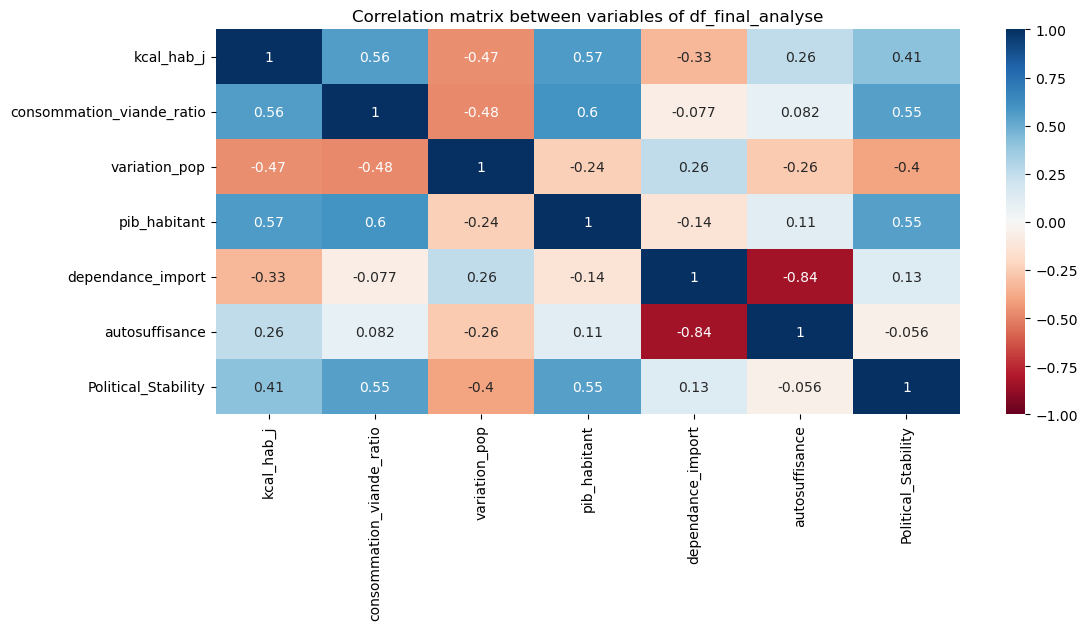

In [24]:
# Correlation matrix between variables
z = df_final_analyse.corr()

fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, 
            center=0, cmap="RdBu",
            vmin = -1, vmax = 1,
            annot=True)
ax.set_title("Correlation matrix between variables of df_final_analyse")
plt.show()

# Part 2 - Principal Component Analysis (PCA)<a class="anchor" id="chapter4"></a>
We now have our final dataframe, we can move on to the PCA. 
A PCA or principal component analysis allows to project on a plane, a scatter plot having more than 3 dimensions. 

In our case, we have 7 variables. The purpose of the PCA is to :
- visualize on the correlation circle the relations between the variables;
- find relationships (variability) between the indexes (in our case, the countries)

In [25]:
# Recovery of the final dataframe as data
data = df_final_analyse.copy()
data.set_index('Zone',inplace=True)         # Indexion by country

values = data.values            # values = quantitative values of all columns
country = data.index            # country = index in our case
features = data.columns         # features/variables = column name

# StanderScaler
std_scale = preprocessing.StandardScaler().fit(values)
values_scaled = std_scale.transform(values)

# Main components
pca = decomposition.PCA(svd_solver='full')
pca.fit(values_scaled)
score_pca = pca.transform(values_scaled)

print("The number of components calculated is :",pca.n_components_)

The number of components calculated is : 7


In [26]:
# Standard Deviation
print(np.std(values_scaled,axis=0))

[1. 1. 1. 1. 1. 1. 1.]


### 2.1 - Determining the number of components to analyze : <a class="anchor" id="section4.1"></a>

**Kaiser and Guttman Rule**
The Kaiser rule is based on a simple idea. In a standardized PCA, the sum of the eigenvalues being equal to the number of variables, their average is 1. We therefore consider an axis to be interesting if its eigenvalue is greater than 1.

**Karlis - Saporata - Spinaki (2003)**
Threshold 1 would be too permissive. A more restrictive rule is to define it as follows: mean of the eigenvalues + 2 times their standard deviation (Saporta, 2006; page 172).
The acceptance rule now becomes : 
$$

\lambda > 1+2\sqrt{\frac{p - 1}{n - 1}}

$$

Compared to the Kaiser rule, it is more restrictive. This goes in the desired direction. \
Note also that it depends on the "n:p" ratio, which is a determining factor in the quality of the PCA results. We will be all the more demanding - we will be inclined to accept fewer factors - the higher the number of variables "p" compared to the available observations "n". 


In [27]:
n = data.shape[0]           # number of observations
p = data.shape[1]           # number of variables

karlis_critical_value = 1+2*np.sqrt((p-1)/(n-1))
print('Karlis critical threshold is',karlis_critical_value.round(3))

# Valeur corrigé : variance expliqué par Tanagra
eigval = (n-1)/n*pca.explained_variance_

# Mis en pourcentage
explained_pourcentage = pca.explained_variance_ratio_*100
explained_pourcentage_cumsum = pca.explained_variance_ratio_.cumsum()*100

print(pd.DataFrame({'Eigenvalues':eigval.round(3), '(%) explained':explained_pourcentage.round(2), '(%) cumulated' : explained_pourcentage_cumsum.round(2)}))

Karlis critical threshold is 1.378
   Eigenvalues  (%) explained  (%) cumulated
0        3.085          44.07          44.07
1        1.857          26.53          70.59
2        0.743          10.61          81.20
3        0.495           7.06          88.27
4        0.392           5.60          93.87
5        0.286           4.08          97.95
6        0.143           2.05         100.00


We will have to analyze only the first 2 components to be above the critical threshold of Karlis.

### 2.2 - Eigenvalue Scaling : <a class="anchor" id="section4.2"></a>

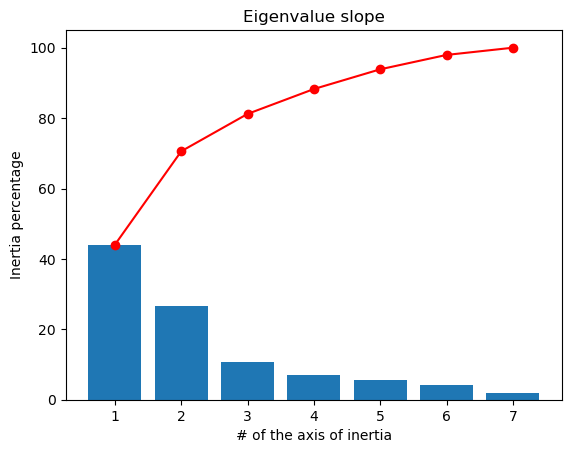

In [28]:
# Eigenvalue Scaling
display_scree_plot(pca)

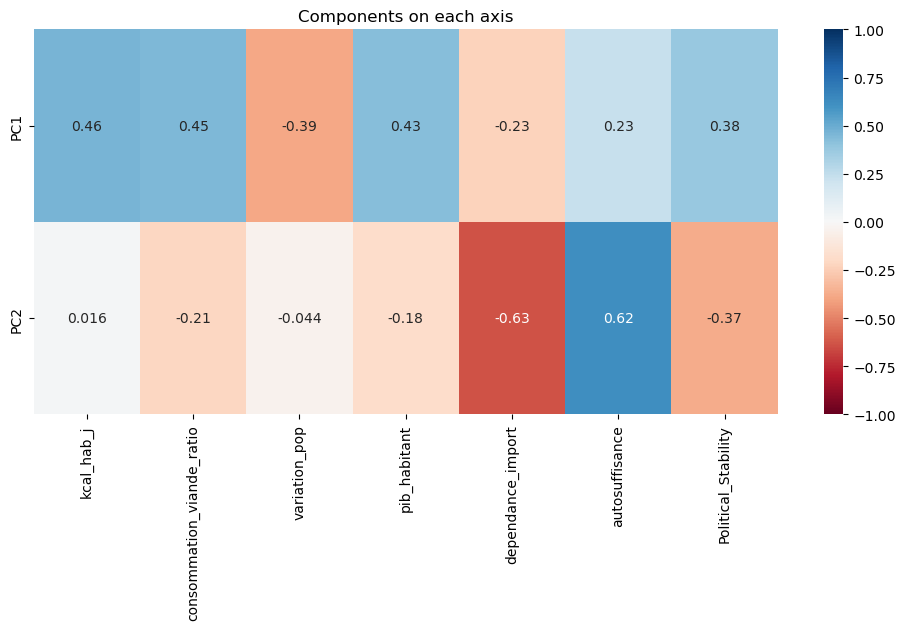

In [29]:
# Number of principal components to analyze
n_comp = 2
pcs = pca.components_

# Coefficient of the principal component 
df_composantePrincipale = pd.DataFrame(pcs, index = ["PC" + str(i+1) for i in range(len(features))], columns = features).round(3)

# Coefficient matrix of the principal component
z = df_composantePrincipale.iloc[:n_comp]

# fig = px.imshow(z, zmin = -1, zmax = 1,
#                 x = features,
#                 color_continuous_scale=[(0, "red"), (0.5, "yellow"), (1, "green")],
#                 # title = 'Matrice de corrélation des composantes principales',
#                 labels = dict(x = 'Features'),
#                 text_auto = '.2f'
#                 )
# fig.update_xaxes(side="top",showline=True, linewidth=2, linecolor='black')
# fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
# # fig.update_layout(title_text = '<b>Matrice de corrélation entre variables</b>', title_x = 0.5, title_y = 1)
# fig.show()

fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, 
            center=0, cmap="RdBu",
            vmin = -1, vmax = 1,
            annot=True)
ax.set_title("Components on each axis")
plt.show()

### 2.3 - Correlation Circle : <a class="anchor" id="section4.3"></a>

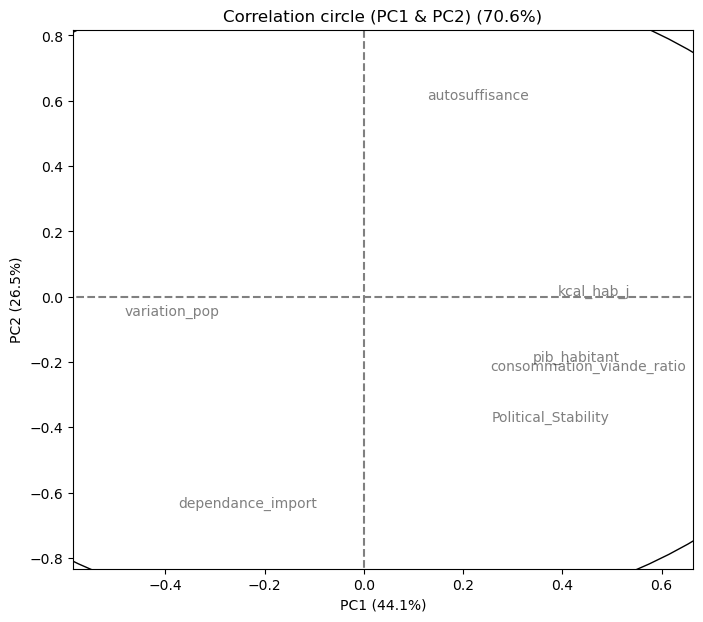

In [30]:
# Correlation Circle
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

**PC1 axis** : positive relationship with gdp, political stability and food availability in contrast to population variation
**PC2 axis** : opposite relationship between import dependence and poultry self-sufficiency.

We will now put the countries on the first factorial axis.

In [31]:
# Graphical representation of countries on the first factorial axis

data = pd.DataFrame(score_pca, index = country, columns = ["PC" + str(i+1) for i in range(len(features))]).iloc[:,:n_comp]
data.reset_index(inplace=True)

# Select PCx :
a = 1
b = a+1

# Graph
PCa = data.iloc[:,a]
PCb = data.iloc[:,b]
PCa_var = 100*pca.explained_variance_ratio_[a-1]
PCb_var = 100*pca.explained_variance_ratio_[b-1]
total_var = PCa_var + PCb_var

fig = px.scatter(data, 
                x=PCa/PCa.max(), 
                y=PCb/PCb.max(), 
                hover_name = data['Zone'],
                labels = {
                    "x" : f'PC{a} ({PCa_var:.2f}%)',
                    "y" : f'PC{b} ({PCb_var:.2f}%)'
                },
                width = 800, height = 600
                )
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')             # Axis line in black
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.add_hline(y=0, line_width = 2, line_dash = 'dash', opacity = .5)
fig.add_vline(x=0, line_width = 2, line_dash = 'dash', opacity = .5)

fig.update_layout(title_text = f'<b>Total Explained Variance: ({total_var:.2f}%)</b>', 
                title_x = 0.5,
                yaxis_range = [-1.1,1.1],
                xaxis_range = [-1.1,1.1])
fig.show()

## 2.4 -Projection Quality Analysis : <a class="anchor" id="section4.4"></a>

### 2.4.1 - Quality of representation of individuals - COS2 (cosine squared) <a class="anchor" id="section4.4.1"></a>
To calculate the quality of representation of the individuals on the axes, we must first calculate the squares of the distances to the origin of the individuals, which also correspond to their contribution to the total inertia.

In [32]:
#  Contribution to total inertia
di = np.sum(values_scaled**2,axis=1)
df_di = pd.DataFrame({'Zone':country,'d_i':di})

df_di.sort_values(by=["d_i"],ascending=False).head(10)          # Top 10 countries with the greatest inertia.

,Zone,d_i
121,Pays-Bas,45.576321
17,Belgique,44.451098
92,Luxembourg,32.615292
76,Islande,23.836033
122,Pérou,22.356021
115,Oman,20.617075
32,Chine - RAS de Macao,18.775592
97,Maldives,17.971922
149,Suisse,17.441888
0,Afghanistan,16.402738


We can see that **Netherlands, Belgium, Luxembourg** are among the countries that contribute to the total inertia.

In [33]:
# Quality of representation of individuals - COS2
cos2 = score_pca**2
for i in range(p):          # p = # features
        cos2[:,i] = cos2[:,i]/di

pd.DataFrame(cos2, index = country, columns = ["COS_" + str(i+1) for i in range(len(features))]).iloc[:,:n_comp]

,COS_1,COS_2
Zone,,
Afghanistan,0.715151,0.035902
Afrique du Sud,0.151861,0.253113
Albanie,0.243210,0.278003
Algérie,0.025373,0.381842
Allemagne,0.905631,0.020550
...,...,...
Venezuela (République bolivarienne du),0.114898,0.247293
Viet Nam,0.055184,0.028726
Yémen,0.653846,0.112347


According to the theory, for each individual, the sum of the COS² on all factors is equal to 1

In [34]:
print(np.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


### 2.4.2 - Contribution of individuals to the axes (CTR) <a class="anchor" id="section4.4.2"></a>
They allow us to determine the individuals who weigh the most in the definition of each factor.

In [35]:
# Contribution to the axes
ctr = score_pca**2
for i in range(p):
    ctr[:,i] = ctr[:,i]/(n*eigval[i])

# Theory testing
print(np.sum(ctr,axis=0))


ctr = pd.DataFrame(ctr, index = country, columns = ["CTR_" + str(i+1) for i in range(len(features))]).iloc[:,:n_comp]
ctr.sort_values(by=['CTR_1'],ascending=False).head(10)

[1. 1. 1. 1. 1. 1. 1.]


,CTR_1,CTR_2
Zone,,
Pays-Bas,0.040141,0.062339
Belgique,0.038996,0.068742
Islande,0.036908,0.006160
Irlande,0.022747,0.001985
Afghanistan,0.022503,0.001877
Danemark,0.021050,0.000972
Yémen,0.020161,0.005755
Norvège,0.019475,0.001960
États-Unis d'Amérique,0.018891,0.000143


In [36]:
ctr.sort_values(by=['CTR_2'],ascending=False).head(10)

,CTR_1,CTR_2
Zone,,
Belgique,3.899624e-02,0.068742
Pays-Bas,4.014101e-02,0.062339
Pérou,5.800309e-04,0.035966
Luxembourg,1.623135e-02,0.034357
Thaïlande,1.935179e-04,0.028882
Chine - RAS de Macao,5.627954e-03,0.027668
Maldives,8.009901e-03,0.025444
Antigua-et-Barbuda,9.615303e-08,0.023925
Mongolie,1.010612e-04,0.023272


For the PC1 axis: **Netherlands, Belgium, Iceland**\
For the PC2 axis: **Belgium, Netherlands, Peru**.

### Representation of variables - Tools to help interpretation

In [37]:
# # Square root of eigenvalues
sqrt_eigval = np.sqrt(eigval)

# Correlation of variables with axes
corvar = np.zeros((p,p))

for i in range(p):
    corvar[:,i] = pcs[i,:] * sqrt_eigval[i]

pd.DataFrame(corvar, index = features, columns = ["COR_" + str(i+1) for i in range(len(features))]).iloc[:,:n_comp]

,COR_1,COR_2
kcal_hab_j,0.813730,0.022166
consommation_viande_ratio,0.794165,-0.291981
variation_pop,-0.678590,-0.060083
pib_habitant,0.751318,-0.252085
dependance_import,-0.410812,-0.862413
autosuffisance,0.403228,0.841595
Political_Stability,0.659832,-0.501910


### 2.4.3 - Quality of variable representation (COS2)  <a class="anchor" id="section4.4.3"></a>
The quality of representation of the variables can be calculated by squaring the correlation.

In [38]:
# Quality of variable representation (COS2)
cos2var = corvar**2
pd.DataFrame(cos2var, index = features, columns = ["COS2_" + str(i+1) for i in range(len(features))]).iloc[:,:n_comp]

,COS2_1,COS2_2
kcal_hab_j,0.662156,0.000491
consommation_viande_ratio,0.630698,0.085253
variation_pop,0.460485,0.003610
pib_habitant,0.564478,0.063547
dependance_import,0.168767,0.743756
autosuffisance,0.162593,0.708283
Political_Stability,0.435378,0.251913


### 2.4.4 - Contribution of the variables to the axes (CTR) <a class="anchor" id="section4.4.4"></a>
The contribution is also based on the square of the correlation, but relativized by the importance of the axis

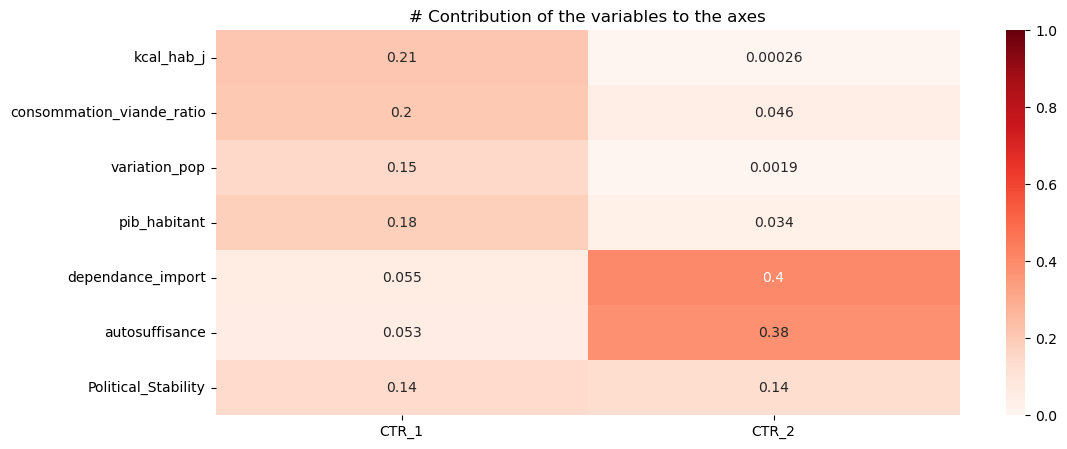

In [39]:
# Contribution of the variables to the axes (CTR)
ctrvar = corvar**2

for i in range(p):
    ctrvar[:,i] = ctrvar[:,i]/eigval[i]

z = pd.DataFrame(ctrvar, index = features, columns = ["CTR_" + str(i+1) for i in range(len(features))]).iloc[:,:n_comp]

fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, 
            cmap="Reds",
            vmin = 0, vmax = 1,
            annot=True)
ax.set_title("# Contribution of the variables to the axes")
plt.show()


This would allow us to add new countries to our PCA analysis.

# Part 3 - Clustering with the hierarchical bottom-up clustering method (dendogram) <a class="anchor" id="chapter5"></a>

The objective of partitioning or clustering is to create homogeneous groups of observations.


The objective here is to group similar countries, we will make a hierarchical ascending classification according to Ward's method.
Ward's method, seeks at each iteration to minimize the increase of intraclass inertia due to the grouping of the 2 clusters. Therefore, we prefer it for the realization of a dendogram.


We will use the data of score_pca, calculated with the PCA previously.

**Advantages and disadvantages of the AHC** :
- Advantage: Unlike k-means, hierarchical clustering does not require to determine a number of classes beforehand

- Disadvantage: This algorithm has a high algorithmic complexity in time and space, i.e. you may run out of time or memory space, even with a medium-sized dataset. Hierarchical clustering is therefore more suitable for small samples.

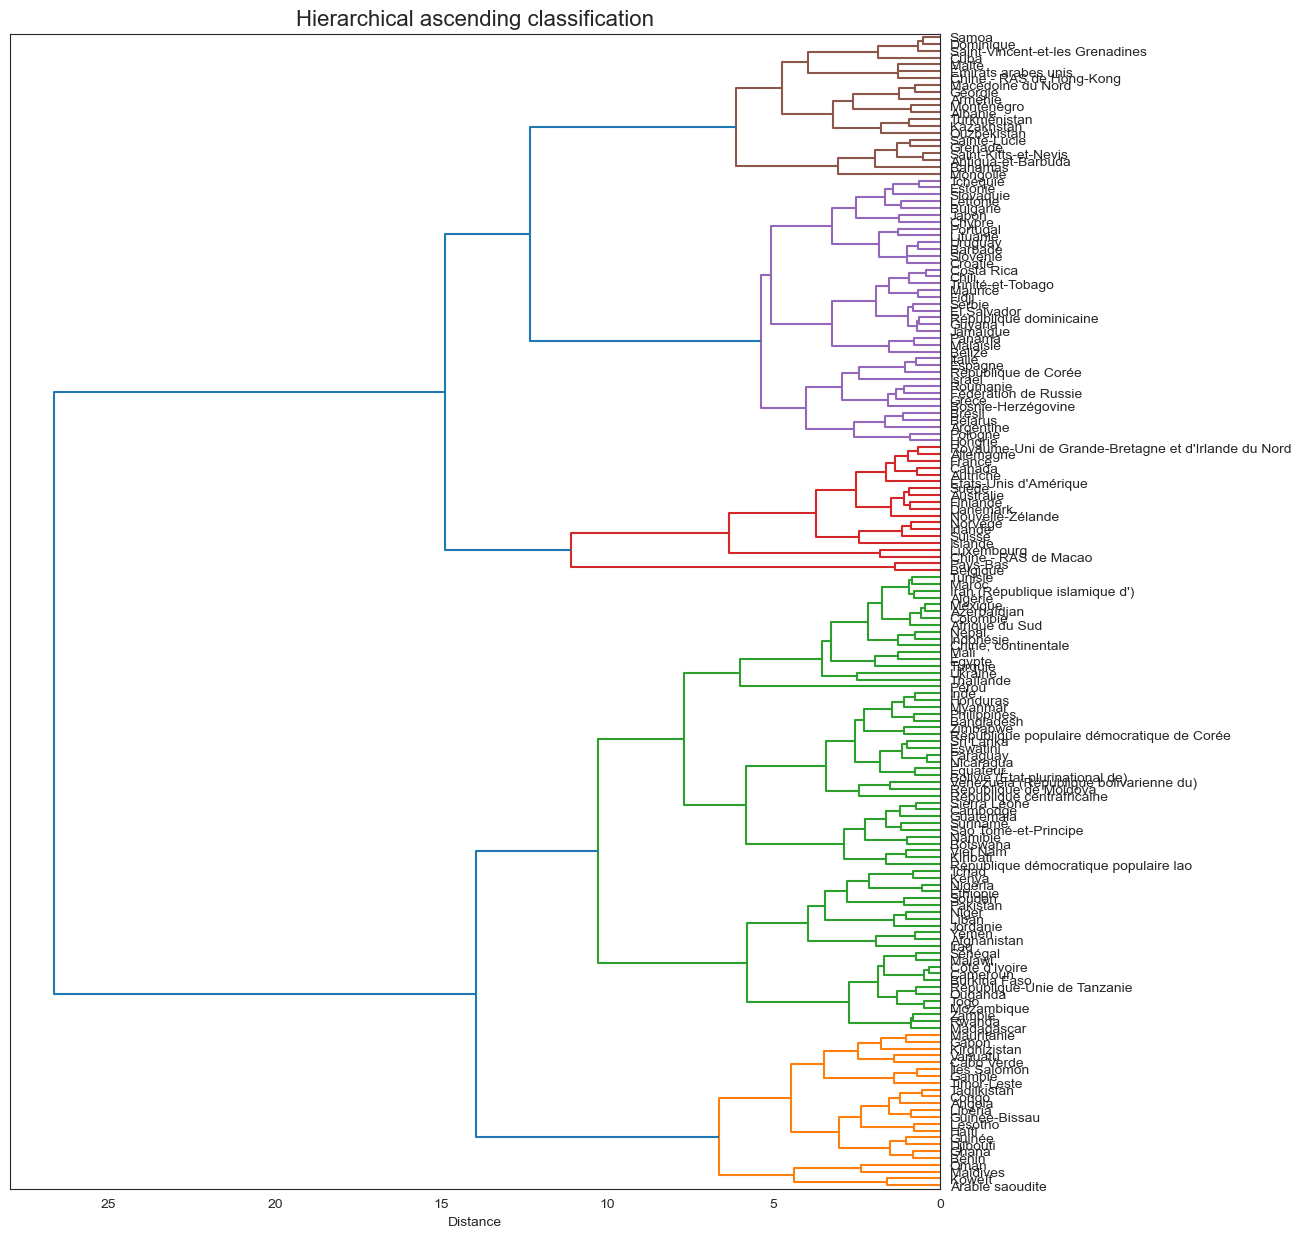

In [40]:
# Hierarchical clustering: Ward's link matrix

clustering = linkage(score_pca, method = 'ward', metric='euclidean')  

#Display of a first global dendrogram
fig = plt.figure(figsize=(12,15))
sns.set_style('white')
plt.title('Hierarchical ascending classification', fontsize=16)
plt.xlabel('Distance')

dendrogram(clustering, labels = country, leaf_font_size=10, color_threshold=12, orientation='left')
plt.show()

We could designate 4 or 5 different groups with the AHC method. We will do the analysis with 5 different groups because 2 countries seem to be outliers according to the PCA.

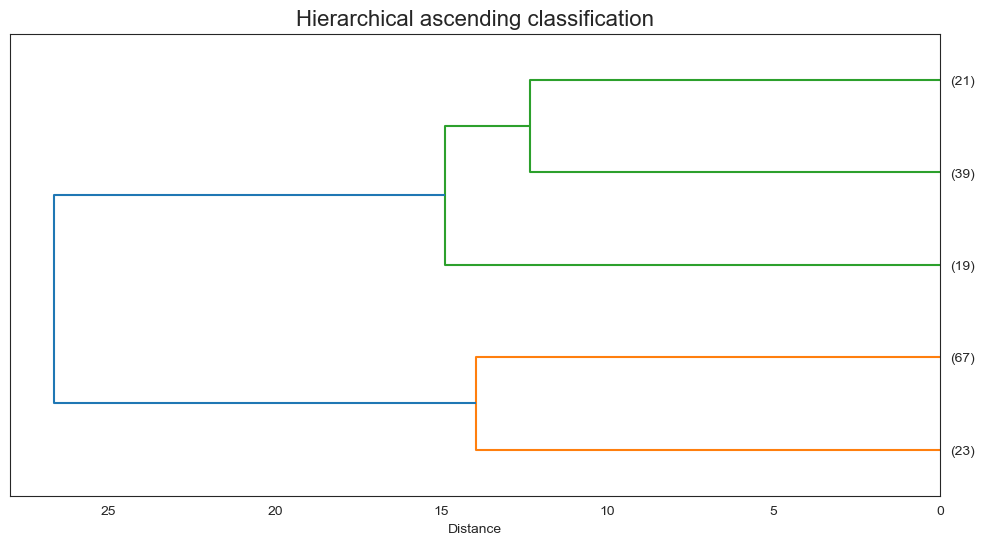

In [41]:
# Cutting at height t = 12 ==> Identification of 5 groups
groupes_cah = fcluster(clustering, 5, criterion = 'maxclust')

# Splitting the dendrogram into 5 groups
fig = plt.figure(figsize=(12,6))
plt.title('Hierarchical ascending classification', fontsize=16)
plt.xlabel('Distance')

dendrogram(clustering, labels = country, p=5, truncate_mode='lastp', leaf_font_size=10, orientation='left')
plt.show()

We will associate each country with its AHC group.

In [42]:
# Sorted index of groups
index_groupe = np.argsort(groupes_cah)

# Show countries by AHC group
groupe_cah = pd.DataFrame(country[index_groupe], groupes_cah[index_groupe]).reset_index()
groupe_cah.rename(columns = {'index':'groupe_cah'},inplace=True)
groupe_cah.head()

,groupe_cah,Zone
0,1,Kirghizistan
1,1,Haïti
2,1,Guinée-Bissau
3,1,Guinée
4,1,Ghana


### 3.1 - Analysis of the different clusters determined by the AHC  <a class="anchor" id="section5.1"></a>

In [43]:
df_groupe_cah = pd.merge(df_final_analyse, groupe_cah, on='Zone')
df_groupe_cah

#First comparison of averages
df_groupe_cah.groupby('groupe_cah').mean()

,kcal_hab_j,consommation_viande_ratio,variation_pop,pib_habitant,dependance_import,autosuffisance,Political_Stability
groupe_cah,,,,,,,
1,2568.260870,10.114554,14.352485,4907.371897,114.394304,19.658087,-0.161739
2,2621.552239,9.881762,9.821315,3096.729003,12.975791,96.006433,-0.760746
3,3441.052632,25.806803,4.398563,59042.310433,-7.191789,115.296947,0.946842
4,3105.461538,20.051173,1.322350,15782.470747,5.934846,115.345718,0.365641
5,2942.571429,23.225807,3.530360,13297.335282,94.194857,18.578619,0.502381


Group 1 and 5 are the two groups with the highest poultry import dependency. The difference between the two is that group 5 has a higher GDP per capita and stability. In addition, they are more likely to consume meat than group 1.

Group 2 corresponds to poorer countries with a fairly high population growth. Political stability is the lowest of all groups.

Group 3 corresponds to developed countries with a high degree of self-sufficiency and a very high GDP per capita. Political stability is the highest.

Group 4 are countries with high poultry self-sufficiency that look quite developed overall.

**In our case, the countries in group 1 and 5 will be the most interesting for the analysis, with a preference for group 5.** We will see which countries are available within.

In [44]:
print("Group 1 countries are :",df_groupe_cah.query("groupe_cah == 1")["Zone"].unique())

print("Group 5 countries are :",df_groupe_cah.query("groupe_cah == 5")["Zone"].unique())

Group 1 countries are : ['Angola' 'Arabie saoudite' 'Bénin' 'Cabo Verde' 'Congo' 'Djibouti'
 'Gabon' 'Gambie' 'Ghana' 'Guinée' 'Guinée-Bissau' 'Haïti' 'Îles Salomon'
 'Kirghizistan' 'Koweït' 'Lesotho' 'Libéria' 'Maldives' 'Mauritanie'
 'Oman' 'Tadjikistan' 'Timor-Leste' 'Vanuatu']
Group 5 countries are : ['Albanie' 'Antigua-et-Barbuda' 'Arménie' 'Bahamas'
 'Chine - RAS de Hong-Kong' 'Cuba' 'Dominique' 'Émirats arabes unis'
 'Géorgie' 'Grenade' 'Kazakhstan' 'Macédoine du Nord' 'Malte' 'Mongolie'
 'Monténégro' 'Ouzbékistan' 'Sainte-Lucie' 'Saint-Kitts-et-Nevis'
 'Saint-Vincent-et-les Grenadines' 'Samoa' 'Turkménistan']


According to the countries, the countries of group 5 are more developed, so we will focus on this country. 

### 3.2 - Heatmap of clusters obtained with AHC <a class="anchor" id="section5.2"></a>

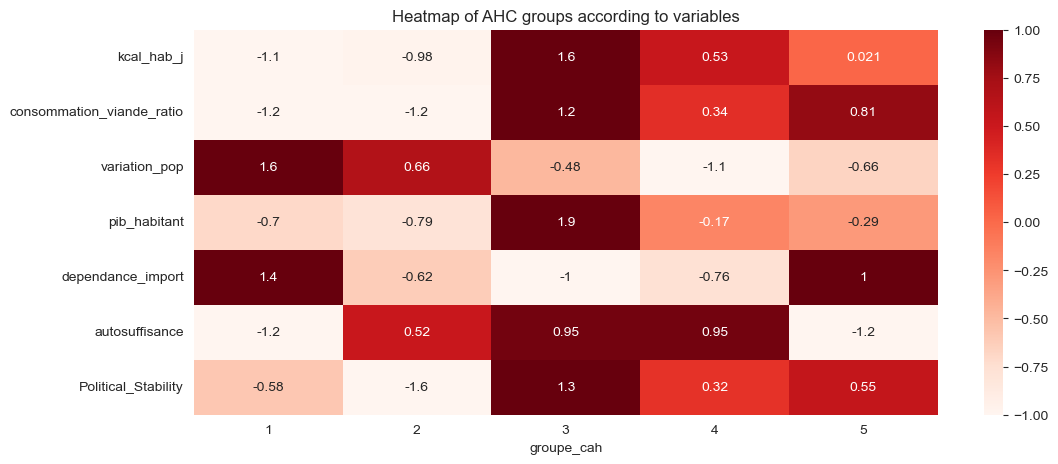

In [45]:
# Heatmap 
test = df_groupe_cah.groupby('groupe_cah').mean()

values = test.values            
groupe_index = test.index            
features = test.columns         

# StandardScaler
std_scale_groupe = preprocessing.StandardScaler().fit(values)
values_scaled_groupe = std_scale_groupe.transform(values)

z = pd.DataFrame(values_scaled_groupe, columns = features, index = groupe_index).transpose()
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, 
            cmap="Reds",
            vmin = -1, vmax = 1,
            annot=True)
ax.set_title("Heatmap of AHC groups according to variables")
plt.show()

# Part 4 - Clustering with the K-means method  <a class="anchor" id="chapter6"></a>
Aim: to find clusters while minimizing the intraclass inertia. To do this, we will use the 'silhouette' metric for different number of clusters and find the adequate number of groups. 

**Advantages and disadvantages of the K-means method** :
- Advantage: The k-means algorithm usually converges very quickly, even with many points. 

- Disadvantage: k-means is not able to determine the optimal number of classes: we have to specify it at the beginning.

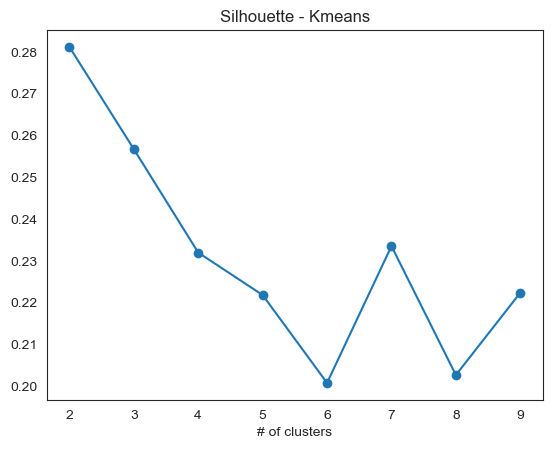

In [46]:
# Clustering with the K-means method
silhouettes = [] 

#Iterative loop from 2 to 10 (clusters) to test the possibilities
for k in range(2, 10): 
    # Create and fit a model for each k
    cls = cluster.KMeans(n_clusters=k, random_state=8)  
    cls.fit(score_pca)
    
    # Associated Coefficients
    silh = metrics.silhouette_score(score_pca, cls.labels_)
    silhouettes.append(silh)
    
# Visualization
plt.plot(range(2, 10), silhouettes, marker='o')
plt.title("Silhouette - Kmeans")
plt.xlabel("# of clusters")
plt.show()

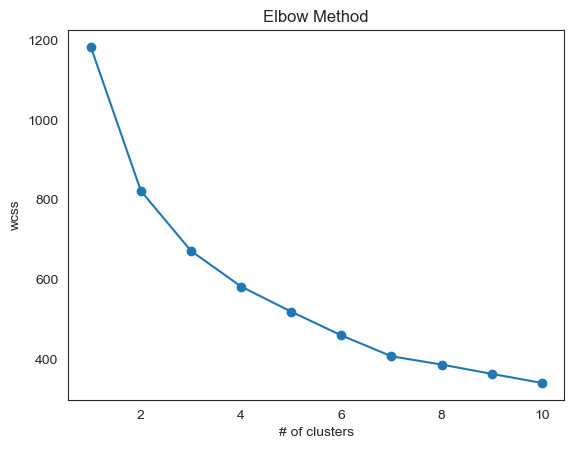

In [47]:
# Inertia
inerties=[]

# Iterative loop from 2 to 10 (clusters) to test the possibilities
for k in range(1, 11):
    # Create and fit a model for each k
    km = cluster.KMeans(n_clusters=k, random_state = 8)
    km.fit(score_pca)
    # Associated Coefficients
    inerties.append(km.inertia_)

# Visualization
plt.plot(range(1, 11), inerties, marker='o')
plt.title('Elbow Method')
plt.xlabel('# of clusters')
plt.ylabel('wcss')
plt.show()

Depending on the elbow method, we could take **4, 5 or 7 clusters**. To match the AHC, we will take 5 clusters and see the difference between the two methods.

### 4.1 - Comparison of clusters obtained between AHC and K-means :  <a class="anchor" id="section6.1"></a>

In [48]:
#Clustering K-Means in 5 clusters
cls = cluster.KMeans(n_clusters=5, random_state = 8)
cls.fit(values_scaled)

clusters_kmeans = cls.labels_

# Crosstab
pd.crosstab(groupes_cah,clusters_kmeans)

col_0,0,1,2,3,4
row_0,,,,,
1,23,0,0,0,0
2,7,0,26,0,34
3,0,1,0,18,0
4,0,7,23,9,0
5,0,20,1,0,0


***As a reminder: we wanted to analyze AHC group 5.***

Group 5 of AHC corresponds to the line with index 5. We realize that the countries inside were separated in other groups, but that the major part is in group 1 in the clustering with K-means.

### 4.2 - Analysis of the different groups determined by K-means :  <a class="anchor" id="section6.2"></a>

In [49]:
# Add K-means group
df_groupe_cah["groupe_kmeans"] = clusters_kmeans
df_groupe_cah.groupby('groupe_kmeans').mean()

,kcal_hab_j,consommation_viande_ratio,variation_pop,pib_habitant,dependance_import,autosuffisance,Political_Stability,groupe_cah
groupe_kmeans,,,,,,,,
0,2583.333333,9.857887,12.992834,4604.129553,100.117633,25.835800,-0.017000,1.233333
1,2947.000000,22.725666,2.516716,17901.543493,83.858607,31.710429,0.611071,4.678571
2,2959.960000,15.720992,4.007528,7763.520112,3.840340,115.454360,-0.228600,2.980000
3,3435.518519,24.768269,2.725666,46340.575578,-16.163963,126.875778,0.792963,3.333333
4,2418.470588,7.880342,13.623374,1711.060132,13.711588,91.250382,-1.131471,2.000000


In [50]:
print("Countries that are in group 5 AHC but not in group 1 K-means are: ",
set(df_groupe_cah.query("groupe_cah == 5")["Zone"].unique()).difference(df_groupe_cah.query("groupe_kmeans == 1")["Zone"].unique()))

print("Countries that are in Group 1 K-means but not in Group 5 AHC are :",
set(df_groupe_cah.query("groupe_kmeans == 1")["Zone"].unique()).difference(df_groupe_cah.query("groupe_cah == 5")["Zone"].unique()))

Countries that are in group 5 AHC but not in group 1 K-means are:  {'Turkménistan'}
Countries that are in Group 1 K-means but not in Group 5 AHC are : {'Chypre', 'Bulgarie', 'Chine - RAS de Macao', 'Lettonie', 'Estonie', 'Slovaquie', 'Tchéquie', 'Japon'}


### 4.3 - Heatmap of the groups obtained with K-means :  <a class="anchor" id="section6.3"></a>

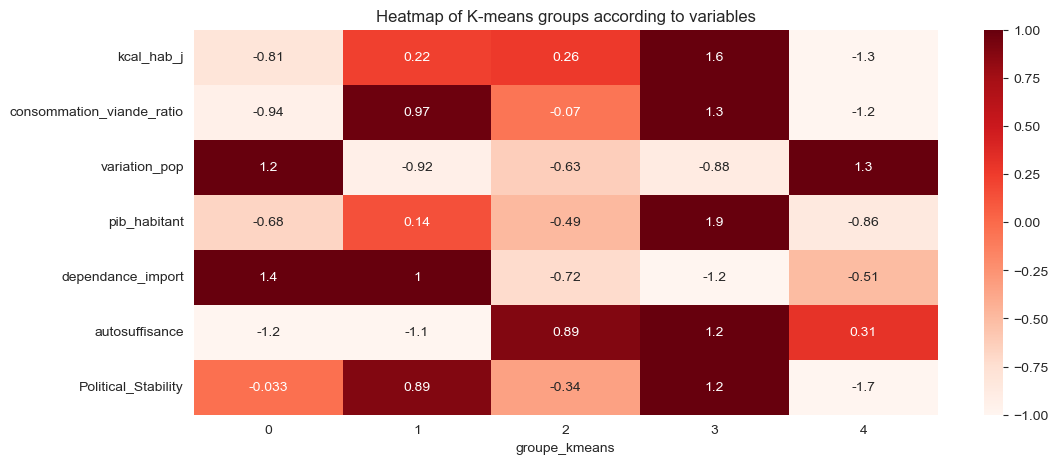

In [51]:
# Heatmap 
test = df_groupe_cah.groupby('groupe_kmeans').mean()
test.drop(["groupe_cah"], axis = 1,inplace=True)

values = test.values           
groupe_index = test.index            
features = test.columns         

# StandardScaler
std_scale_groupe = preprocessing.StandardScaler().fit(values)
values_scaled_groupe = std_scale_groupe.transform(values)

z = pd.DataFrame(values_scaled_groupe, columns = features, index = groupe_index).transpose()
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, 
            cmap="Reds",
            vmin = -1, vmax = 1,
            annot=True)
ax.set_title("Heatmap of K-means groups according to variables")
plt.show()

In [52]:
# Zone - PC1 - PC2 & group
data = pd.DataFrame(score_pca, index = country, columns = ["PC" + str(i+1) for i in range(len(features))]).iloc[:,:n_comp]
data.reset_index(inplace=True)
data = pd.merge(data, groupe_cah, on='Zone')           
data['groupe_kmeans'] = clusters_kmeans      
data['groupe_cah'] = data['groupe_cah'].astype(str)           
data['groupe_kmeans'] = data['groupe_kmeans'].astype(str)          
data.head()

,Zone,PC1,PC2,groupe_cah,groupe_kmeans
0,Afghanistan,-3.424973,0.767398,2,4
1,Afrique du Sud,-0.247317,0.319292,2,2
2,Albanie,1.427847,-1.526568,5,1
3,Algérie,-0.287174,1.114035,2,2
4,Allemagne,2.568901,-0.386969,3,3


# Part 5 -  Visualization of the groups on the PCA <a class="anchor" id="chapter7"></a>

In [53]:
# Select PCx :
a = 1
b = a+1

# Select group :
groupe_select = "groupe_cah"

# Graph
PCa = data.iloc[:,a]
PCb = data.iloc[:,b]
PCa_var = 100*pca.explained_variance_ratio_[a-1]
PCb_var = 100*pca.explained_variance_ratio_[b-1]
total_var = PCa_var + PCb_var

fig = px.scatter(data, 
                x=PCa/PCa.max(), 
                y=PCb/PCb.max(), 
                color = data[groupe_select], 
                category_orders={groupe_select : ['0','1','2','3','4','5','6']},
                hover_name = data['Zone'],
                labels = {
                    "x" : f'PC{a} ({PCa_var:.2f}%)',
                    "y" : f'PC{b} ({PCb_var:.2f}%)'
                },
                width = 800, height = 600
                )
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')             # Axis lines in black
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.add_hline(y=0, line_width = 2, line_dash = 'dash', opacity = .5)
fig.add_vline(x=0, line_width = 2, line_dash = 'dash', opacity = .5)

fig.update_layout(title_text = f'<b>Total Explained Variance: ({total_var:.2f}%)</b>', 
                title_x = 0.5,
                yaxis_range = [-1.1,1.1],
                xaxis_range = [-1.1,1.1])
fig.show()

We notice that the countries of group 1 for the K-means are the most relevant for our analysis with the representation on the PCA.

If we look at the world map, we can see these countries below: 

In [54]:
# MAP
df_final_ISO = pd.merge(df_groupe_cah, ISO_code, on='Zone', how='left')

# Show missing values
df_final_ISO[df_final_ISO.isna().any(axis=1)]

,Zone,kcal_hab_j,consommation_viande_ratio,variation_pop,pib_habitant,dependance_import,autosuffisance,Political_Stability,groupe_cah,groupe_kmeans,ISO3
33,"Chine, continentale",3197.0,11.385674,2.659675,8663.125742,-0.708,104.099,-0.23,2,2,NaN


In [55]:
# # See the code that corresponds to China, mainland
ISO_code.loc[ISO_code["Zone"].str.contains("Chin", case = False)]

,ISO3,Zone
57,CHN,Chine
58,HKG,Chine - RAS de Hong-Kong
59,MAC,Chine - RAS de Macao
268,TWN,Province chinoise de Taïwan


The ISO code calls **China, Mainland**: **China**. We will therefore manually assign its ISO code to China.

In [56]:
# ISO change
df_final_ISO.at[33,"ISO3"] = 'CHN'

# Checking
df_final_ISO.loc[df_final_ISO["Zone"].str.contains("Chin", case = False)]

,Zone,kcal_hab_j,consommation_viande_ratio,variation_pop,pib_habitant,dependance_import,autosuffisance,Political_Stability,groupe_cah,groupe_kmeans,ISO3
31,Chine - RAS de Hong-Kong,3353.0,27.020579,3.682129,46705.027813,62.404,6.138,0.83,5,1,HKG
32,Chine - RAS de Macao,2999.0,19.473158,10.379779,81516.664768,109.524,14.286,1.43,3,1,MAC
33,"Chine, continentale",3197.0,11.385674,2.659675,8663.125742,-0.708,104.099,-0.23,2,2,CHN


## 5.1 - Representation on a world map of the different groups <a class="anchor" id="section7.1"></a>
*Change the **groupe_name** variable to determine the clustering method

In [57]:
# Map representation

# Select clustering method :
groupe_name = 'groupe_kmeans'

df_final_ISO[groupe_name] = df_final_ISO[groupe_name].astype(str)
fig = px.choropleth(df_final_ISO, locations="ISO3",
                    color=groupe_name, # lifeExp is a column of gapminder
                    hover_name="Zone", # column to add to hover information
                    category_orders={groupe_name : ['0','1','2','3','4','5','6']},
                    )
fig.show()

To create a list of countries to export to, we will choose countries that belong to the 1 K-means group. To get a market, we will take only countries with a population higher than **1 million**. We can propose a total of 18 countries. 

In [58]:
df_choix_pays = pd.merge(df_final, df_final_ISO[["Zone","groupe_cah","groupe_kmeans","ISO3"]], on = "Zone", how = 'right')
df_choix_pays.query("groupe_kmeans == '1' & pop2017 >= 1000").sort_values(by = "Importations - Quantité_vol",ascending=False).head(10)

,Zone,Total_kcal/hab/j,Vegetal_kcal/hab/j,Animal_kcal/hab/j,ratioKcalAnimalTotal,pop2012,pop2017,variation_pop,Disponibilité intérieure_vol,Importations - Quantité_vol,...,Nourriture_vol,Production_vol,dependance_import,autosuffisance,pib_habitant,ENGLISH_LIST NAME,Political_Stability,groupe_cah,groupe_kmeans,ISO3
80,Japon,2699.0,2070.0,451.0,16.709893,128423.571,127502.725,-0.717038,2415.0,1069.0,...,2359.0,2215.0,44.892,93.896,38170.669761,Japan,1.11,4,1,JPN
31,Chine - RAS de Hong-Kong,3353.0,1809.0,906.0,27.020579,7046.848,7306.322,3.682129,280.0,907.0,...,391.0,24.0,62.404,6.138,46705.027813,"China, Hong Kong SAR",0.83,5,1,HKG
46,Émirats arabes unis,3370.0,2645.0,597.0,17.715134,9141.596,9487.203,3.780598,412.0,433.0,...,412.0,48.0,82.282,11.650,40644.804043,United Arab Emirates,0.62,5,1,ARE
40,Cuba,3409.0,2790.0,390.0,11.440305,11257.104,11339.254,0.729761,342.0,312.0,...,269.0,29.0,115.985,10.781,8541.214440,Cuba,0.65,5,1,CUB
82,Kazakhstan,3195.0,2161.0,857.0,26.823161,16751.525,18080.019,7.930585,331.0,174.0,...,330.0,171.0,50.909,51.818,9225.974208,Kazakhstan,0.04,5,1,KAZ
153,Tchéquie,3275.0,2281.0,718.0,21.923664,10581.293,10641.034,0.564591,249.0,116.0,...,234.0,163.0,38.034,69.658,20545.836143,Czechia,1.00,4,1,CZE
24,Bulgarie,2827.0,2040.0,556.0,19.667492,7334.003,7102.444,-3.157334,157.0,108.0,...,157.0,107.0,40.127,68.153,8300.173316,Bulgaria,0.33,4,1,BGR
144,Slovaquie,2771.0,1789.0,747.0,26.957777,5414.889,5447.900,0.609634,74.0,63.0,...,76.0,71.0,36.842,93.421,17528.667005,Slovakia,0.91,4,1,SVK
59,Géorgie,2871.0,2322.0,460.0,16.022292,4064.106,4008.716,-1.362907,61.0,51.0,...,61.0,22.0,75.410,36.066,4051.839171,Georgia,-0.37,5,1,GEO
88,Lettonie,3170.0,2087.0,772.0,24.353312,2069.016,1951.097,-5.699279,41.0,43.0,...,41.0,33.0,56.098,80.488,15611.095187,Latvia,0.46,4,1,LVA


In [59]:
print("The list of Group 1 K-means countries, with a population of more than 1 million and sorted according to the amount of poultry imports are : ",
df_choix_pays.query("groupe_kmeans == '1' & pop2017 >= 1000").sort_values(by = "Importations - Quantité_vol",ascending=False)["Zone"].unique())

The list of Group 1 K-means countries, with a population of more than 1 million and sorted according to the amount of poultry imports are :  ['Japon' 'Chine - RAS de Hong-Kong' 'Émirats arabes unis' 'Cuba'
 'Kazakhstan' 'Tchéquie' 'Bulgarie' 'Slovaquie' 'Géorgie' 'Lettonie'
 'Macédoine du Nord' 'Albanie' 'Arménie' 'Estonie' 'Chypre' 'Mongolie'
 'Ouzbékistan']


## 5.2 - World map of the countries in the selected group <a class="anchor" id="section7.2"></a>

The countries represented are the countries of group 1 with a population higher than 1 million inhabitants. Smaller countries are not represented on the map like Hong-Kong for example but are well present in the group. 

In [60]:
#Map representation
data_map = df_choix_pays.query("groupe_kmeans == '1' & pop2017 >= 1000").copy()

# Select clustering method :
groupe_name = 'groupe_kmeans'

# data_map[groupe_name] = data_map[groupe_name].astype(str)
fig = px.choropleth(data_map, 
                    locations="ISO3",
                    color=groupe_name, # 
                    hover_name="Zone", # column to add to hover information
                    category_orders={groupe_name : ['0','1','2','3','4','5','6']},
                    )
fig.show()

## 5.3 - Decision track for selected countries <a class="anchor" id="section7.3"></a>

It is noted that the majority of countries come from Eurasia. 

- **Japan, Hong Kong and UAE** are the countries that import the most poultry; 
- **Japan, Kazakhstan** are the most populated countries; 
- **Mongolia, Albania and Hong Kong** are the countries with the highest meat consumption (40%, 30%, 27% respectively); 
- **Mongolia** does not produce meat at all

These are some guidelines to decide which countries we can export to. Nevertheless, the final choice will be decided during the meeting with our manager.